### Imports

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Create FC NN

In [171]:
# class CNN(nn.Module):
#     def __init__(self, in_channels = 1, num_classes = 10):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # same convolution
#         self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1)) 
#         self.fc3 = nn.Linear(16*7*7, num_classes)
    
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = self.fc3(x)
#         return x

In [172]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        
        # conv
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,8,3,1,1, bias = True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(8,16,3,1,1, bias = True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        
        # fc
        self.layer3 = nn.Sequential(
            nn.Linear(16*7*7, num_classes, bias = True)
        )
    
    def forward(self, x):
        # conv
        out = self.layer1(x)
        out = self.layer2(out)
        
        # fc
        out = out.reshape(out.shape[0], -1)
        out = self.layer3(out)
        return out

### Set Device

In [173]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [174]:
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

### Load Data

In [175]:
train_dataset = datasets.MNIST(root='datasets/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='datasets/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Initialize Network

In [176]:
model = CNN(in_channels = 1, num_classes = num_classes).to(device)

### Loss and Optimizer

In [177]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Check accuracy

In [178]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad(): ## when check accuracy, no need to check gradients
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x) # 64 x 10 dim
            _, predictions = scores.max(1) # axis = 1

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0) # 64
        
        accuracy = float(num_correct) / float(num_samples)*100
    
    return accuracy

### Train NN

In [179]:
def train_model(model, train_loader, test_loader, num_epochs=10, print_every = 1):
    model.train()
    
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
                
            # Forwardprop
            scores = model(data)
            loss = loss_fn(scores, targets)

            # Backwardprop
            optimizer.zero_grad()
            loss.backward()

            # Gradient Descent - Adam Optimization
            optimizer.step()
        
        # Accuracy
        print(f'Epoch {epoch+1}| Test Accuracy: {check_accuracy(test_loader, model):.2f}% | Train Accuracy: {check_accuracy(train_loader, model):.2f}%')
#       

In [181]:
train_model(model, train_loader, test_loader)

Epoch 1| Test Accuracy: 97.23% | Train Accuracy: 97.07%
Epoch 2| Test Accuracy: 97.67% | Train Accuracy: 97.67%


KeyboardInterrupt: 

### Test Set Prediction Visualization

In [156]:
testX = [x for x,y in test_dataset]
testX = [x.unsqueeze(0) for x in testX]
testY = [y for x,y in test_dataset]
testPred = [torch.argmax(model(x)).item() for x in testX]

In [162]:
random_indices = np.random.choice(10000, 49, replace=False)

testX_temp = [testX[i] for i in random_indices]
testY_temp = [testY[i] for i in random_indices]
testPred_temp = [testPred[i] for i in random_indices]

### Visualizing test set predictions

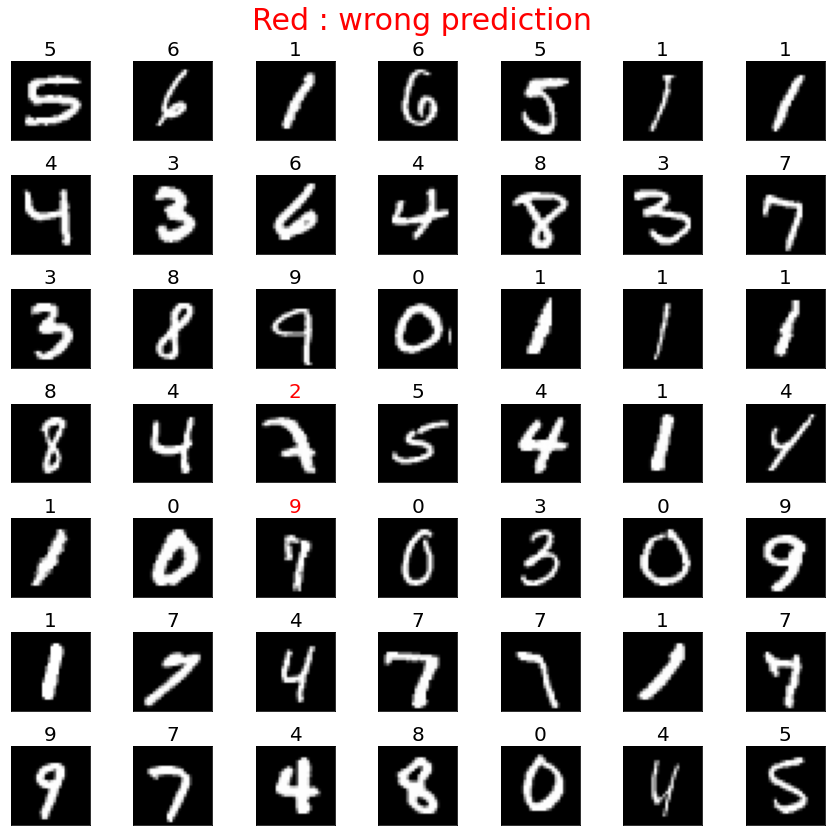

In [169]:
plt.figure(figsize=(12,12))
plt.suptitle('Red : wrong prediction', size = 30, color='red')
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.tight_layout()
    plt.imshow(testX_temp[i].squeeze(), cmap='gray')
    color = "black" if (testPred_temp[i] == testY_temp[i]) else "red"
    plt.title(testPred_temp[i], color=color, size = 20)
    plt.xticks([])
    plt.yticks([])